In [1]:
import pandas as pd
import numpy as np
import math

import networkx as nx

import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

import glob
import pickle

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from statsmodels.api import Logit

In [2]:
sns.set()
matplotlib.rcParams["figure.figsize"] = [12, 10]

### import data

In [3]:
files = sorted(glob.glob("output_data/*.csv"))

In [4]:
def get(nth):

    df = pd.read_csv(files[nth])
    if "Unnamed: 0" in df.columns:
        return df.drop("Unnamed: 0", axis=1)
    return df

In [6]:
{i: f for i, f in enumerate(files)}

{0: 'output_data/all_articles.csv',
 1: 'output_data/all_hyperlink_edges.csv',
 2: 'output_data/category_data.csv',
 3: 'output_data/category_edges.csv',
 4: 'output_data/field_dummies.csv',
 5: 'output_data/randomized_field_coeff_matrix.csv',
 6: 'output_data/randomized_field_data.csv',
 7: 'output_data/randomized_field_link_matrix.csv',
 8: 'output_data/randomized_field_links.csv',
 9: 'output_data/randomized_hyperlink_edges.csv',
 10: 'output_data/randomized_node_data.csv',
 11: 'output_data/randomized_reg_df.csv',
 12: 'output_data/wiki_all_hyperlink_edges.csv',
 13: 'output_data/wiki_field_coeff_matrix.csv',
 14: 'output_data/wiki_field_data.csv',
 15: 'output_data/wiki_field_link_matrix.csv',
 16: 'output_data/wiki_field_links.csv',
 17: 'output_data/wiki_hyperlink_edges.csv',
 18: 'output_data/wiki_node_data.csv',
 19: 'output_data/wiki_reg_df.csv'}

In [7]:
rand_edges = get(9).values

In [19]:
wiki_edges = get(17).values

In [23]:
randomized_df = get(10).drop(["within_field_out_degree", "within_field_in_degree", "color"],axis=1)

In [8]:
filtered = get(18)

In [39]:
randomized_df = pd.concat(
    [
        randomized_df,
        randomized_df.merge(
            filtered[["node", "category", "field"]],
            how="outer",
            on=["node", "category", "field"],
        )
        .loc[lambda df: df["index"].isna(), ["field", "category", "node"]]
        .merge(
            randomized_df.drop(["field", "category"], axis=1).drop_duplicates(),
            how="left",
            on="node",
        ),
    ]
)

In [40]:
randomized_df

,index,field,category,node,title,in_degree,out_degree,neighbor_conn,clustering
0,0,mathematics,Mathematical_theorems,4,Zariski's main theorem,3,0,9.666667,0.000000
1,1,mathematics,Mathematical_theorems,5,FultonHansen connectedness theorem,1,0,13.000000,0.000000
2,2,mathematics,Mathematical_theorems,8,Bing's recognition theorem,1,3,155.750000,0.083333
3,3,political science,Political_theories,93,Land and liberty (slogan),1,0,7.000000,0.000000
4,4,philosophy,British_philosophers,94,John Levy (philosopher),0,1,26.000000,0.000000
...,...,...,...,...,...,...,...,...,...
1420,26913,sociology,Socioeconomics,1099191,Receiver operating characteristic,6,10,227.500000,0.004167
1421,1177,sociology,Socioeconomics,9625,Quality of life,70,12,63.585366,0.003011
1422,37612,sociology,Socioeconomics,1716616,Physical Quality of Life Index,1,2,68.000000,0.000000
1423,36449,sociology,Socioeconomics,1715042,Gini coefficient,33,19,78.653846,0.006787


In [254]:
fields = get(8)[["large_field", "field", "n_articles", "weighted_articles", "rel_size"]]

In [259]:
field_dummies = get(9).set_index("node").sort_index()

### build network

In [62]:
g = nx.DiGraph()

In [63]:
g.add_nodes_from(set(filtered["node"]))

In [64]:
g.add_edges_from(edges)

In [65]:
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 39710
Number of edges: 287725
Average in degree:   7.2457
Average out degree:   7.2457


### degree-preserving randomization

In [33]:
filtered = (
    filtered.sort_values("node")
    .reset_index(drop=True)
    .merge(
        filtered.sort_values("node")
        .drop_duplicates("node")
        .reset_index(drop=True)
        .reset_index()[["index", "node"]],
        on="node",
    )
)

In [35]:
in_degrees = filtered.drop_duplicates("node")["in_degree"].values

In [36]:
out_degrees = filtered.drop_duplicates("node")["out_degree"].values

In [71]:
joint_degrees = (
    filtered.loc[filtered["out_degree"] != 0]
    .groupby("out_degree")
    .apply(
        lambda df: pd.Series(
            [
                g.in_degree(n)
                for n in sum([list(g.successors(n)) for n in df["node"].unique()], [])
            ]
        )
        .value_counts()
        .to_dict()
    )
    .to_dict()
)

In [77]:
joint_rand_g = nx.directed_joint_degree_graph(in_degrees, out_degrees, joint_degrees, seed=0)

In [78]:
print(nx.info(joint_rand_g))

Name: 
Type: DiGraph
Number of nodes: 39710
Number of edges: 287725
Average in degree:   7.2457
Average out degree:   7.2457


In [231]:
rand_edges = list(joint_rand_g.edges())

In [214]:
pd.DataFrame(rand_edges, columns=["from", "to"]).to_csv(
    "output_data/randomized_hyperlink_edges.csv"
)

In [217]:
randomized_df = filtered[
    ["index", "field", "category", "node", "title", "color"]
].merge(
    pd.DataFrame.from_dict(dict(joint_rand_g.in_degree()), orient="index")
    .rename(columns={0: "in_degree"})
    .merge(
        pd.DataFrame.from_dict(dict(joint_rand_g.out_degree()), orient="index").rename(
            columns={0: "out_degree"}
        ),
        left_index=True,
        right_index=True,
    ),
    left_on="index",
    right_index=True,
)

### add network attributes

In [103]:
def neighbor_connectivity(node, graph, weighted, directed):

    w = "weight" if weighted else None

    if directed:
        arr = np.array(
            [
                graph.in_degree(n, weight=w) + graph.out_degree(n, weight=w)
                for n in list(graph.successors(node)) + list(graph.predecessors(node))
            ]
        )

    else:

        arr = np.array([graph.degree(n, weight=w) for n in list(graph.neighbors(node))])

    if arr.shape[0] == 0:
        return 0
    return arr.mean()

In [104]:
def clustering(node, graph):
    
    return nx.clustering(graph, node)

In [105]:
randomized_df = randomized_df.merge(
    randomized_df[["index"]]
    .drop_duplicates()
    .assign(
        neighbor_conn=lambda df: df["index"].apply(
            neighbor_connectivity, args=(joint_rand_g, False, True)
        ),
        clustering=lambda df: df["index"].apply(clustering, graph=joint_rand_g),
    ),
    on="index",
)

### describe fields

In [235]:
randomized_field_links = (
    (
        pd.DataFrame(rand_edges, columns=["from", "to"])
        .merge(
            randomized_df[["index", "field"]].drop_duplicates(),
            left_on="from",
            right_on="index",
        )
        .drop("index", axis=1)
        .rename(columns={"field": "edge_from"})
        .merge(
            randomized_df[["index", "field"]].drop_duplicates(),
            left_on="to",
            right_on="index",
        )
        .drop("index", axis=1)
        .rename(columns={"field": "edge_to"})
    )
    .groupby(["from", "to"])
    .apply(lambda df: df.assign(weight=1 / df.shape[0]))
    .reset_index(drop=True)
)

In [238]:
randomized_df = (
    randomized_df.merge(
        pd.DataFrame(
            randomized_field_links.loc[lambda df: df["edge_from"] == df["edge_to"]]
            .groupby(["from", "edge_from"])["weight"]
            .sum()
        )
        .reset_index()
        .rename(
            columns={
                "from": "index",
                "edge_from": "field",
                "weight": "within_field_out_degree",
            }
        ),
        how="left",
        on=["index", "field"],
    )
    .merge(
        pd.DataFrame(
            randomized_field_links.loc[lambda df: df["edge_from"] == df["edge_to"]]
            .groupby(["to", "edge_to"])["weight"]
            .sum()
        )
        .reset_index()
        .rename(
            columns={
                "to": "index",
                "edge_to": "field",
                "weight": "within_field_in_degree",
            }
        ),
        how="left",
        on=["index", "field"],
    )
    .fillna(0)
)

In [241]:
randomized_field_link_matrix = randomized_field_links.pivot_table(
    columns="edge_to", index="edge_from", values="weight", aggfunc="sum"
)

In [262]:
fields = fields.assign(
    ext_citations=fields["field"].apply(
        lambda f: (
            randomized_field_link_matrix.loc[:, f].sum()
            - randomized_field_link_matrix.loc[f, f]
        )
    )
).assign(
    rel_ext_use=lambda df: df["ext_citations"]
    / randomized_field_link_matrix.sum().sum()
    * (1 - fields["rel_size"])
    / fields["rel_size"],
    ext_cit_avg=lambda df: df["ext_citations"] / fields["weighted_articles"],
    imp_exp_ratio=lambda df: df["ext_citations"]
    / fields["field"].apply(
        lambda f: (
            randomized_field_link_matrix.loc[f].sum()
            - randomized_field_link_matrix.loc[f, f]
        )
    ),
)

In [264]:
fields = fields.merge(
    pd.DataFrame(randomized_field_links.groupby("edge_from")["weight"].sum())
    .reset_index()
    .rename(columns={"edge_from": "field", "weight": "field_out_degree"}),
    on="field",
).merge(
    pd.DataFrame(randomized_field_links.groupby("edge_to")["weight"].sum())
    .reset_index()
    .rename(columns={"edge_to": "field", "weight": "field_in_degree"}),
    on="field",
)

#### save all

In [269]:
fields.to_csv("output_data/randomized_field_data.csv")

In [270]:
randomized_field_links.to_csv("output_data/randomized_field_links.csv")

In [271]:
randomized_field_link_matrix.to_csv("output_data/randomized_field_link_matrix.csv")

In [272]:
randomized_df.to_csv("output_data/randomized_node_data.csv")

Text(0.5, 1.0, 'Distribution of hyperlinks between fields in randomized network\n')

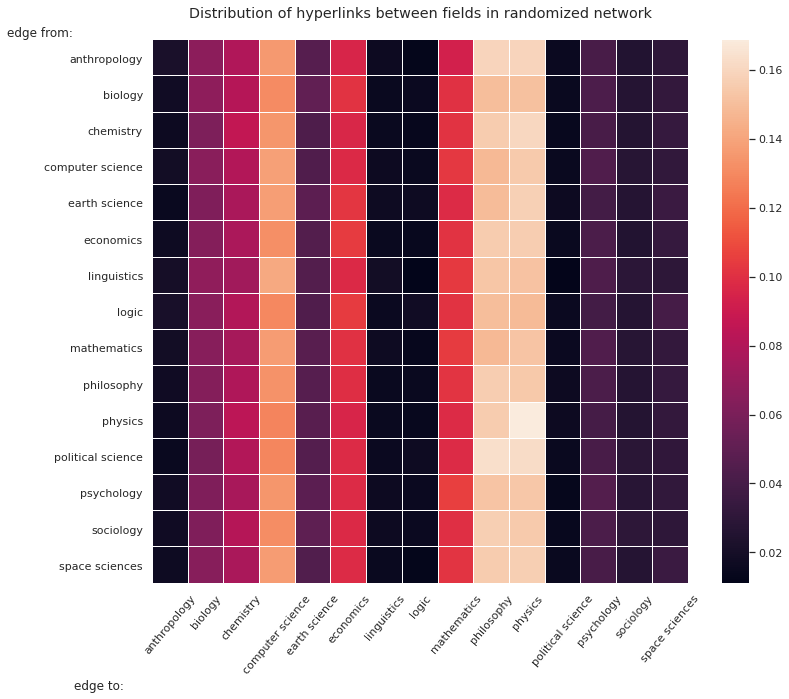

In [301]:
fig, ax = plt.subplots()
ax.set_facecolor("black")

sns.heatmap(
    randomized_field_link_matrix.div(randomized_field_link_matrix.sum(axis=1), axis=0),
    linewidths=0.01,
)
plt.xlabel("edge to:", position=(-0.1, 0))
plt.xticks(rotation=50)
plt.ylabel("edge from:", rotation=0, position=(0, 1))
plt.title(
    "Distribution of hyperlinks between fields in randomized network\n",
    fontsize="large",
)

In [143]:
def roundup(x):

    dec = 10 ** int(np.log10(x))
    return math.ceil(x / dec) * dec

In [144]:
def fields_bar_chart(attr, title):

    sorted_fields = fields.sort_values(attr, ascending=False)

    plt.bar(
        sorted_fields["field"].values,
        sorted_fields[attr].values,
        color=sns.cubehelix_palette(fields.shape[0]),
    )

    plt.xticks(rotation=30)
    plt.ylim(0, roundup(sorted_fields[attr].max()))

    for idx, r in enumerate(sorted_fields[attr]):
        plt.text(x=idx - 0.25, y=1.01 * r, s=round(r, 2), size=12)

    plt.title(title, fontsize="x-large")

### predicting field with network attributes

In [285]:
reg_df = (
    randomized_df.drop_duplicates(["node", "field"])
    .groupby("node")
    .mean()
    .assign(
        p_within_field_in=lambda df: df["within_field_in_degree"] / df["in_degree"],
        p_within_field_out=lambda df: df["within_field_out_degree"] / df["out_degree"],
    )
    .fillna(0)
    .drop(
        ["index", "in_degree", "within_field_out_degree", "within_field_in_degree"],
        axis=1,
    )
)

In [299]:
reg_df.to_csv("output_data/randomized_reg_df.csv")

In [286]:
X = pd.DataFrame(
    StandardScaler().fit_transform(reg_df), columns=reg_df.columns, index=reg_df.index,
).assign(const=1)

In [287]:
reg_metrics = {}

In [288]:
def logit_model(target_var):

    y = field_dummies.sort_values("node")[target_var]

    logit = Logit(y, X).fit()
    prediction = logit.predict(X)

    false_pos, true_pos, tresholds = metrics.roc_curve(y, prediction)
    auc = metrics.roc_auc_score(y, prediction)
    prec, rec, tresholds = metrics.precision_recall_curve(y, prediction)

    reg_metrics.update(
        {
            target_var: {
                "false_pos": false_pos,
                "true_pos": true_pos,
                "auc": auc,
                "prec": prec,
                "rec": rec,
            }
        }
    )
    
    return pd.DataFrame(
        [logit.params.rename("coeffs"), logit.pvalues.rename("p")]
    ).assign(field=target_var)

In [289]:
all_results = pd.concat(
    [logit_model(field) for field in fields["field"]]
)

Optimization terminated successfully.
         Current function value: 0.463683
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.050608
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.401674
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.246580
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.226586
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.223220
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.294597
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.189868
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.095774
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.112129


In [315]:
with open("output_data/randomized_reg_metrics.p", "wb") as fp:
    pickle.dump(reg_metrics, fp)

In [290]:
randomized_field_coeff_matrix = (
    all_results.groupby("field")
    .apply(
        lambda df: df.loc["coeffs"]
        * (0.01 > df.loc["p"]).astype(int).replace(0, np.nan)
    )
    .drop("const", axis=1)
)

In [293]:
randomized_field_coeff_matrix.to_csv("output_data/randomized_field_coeff_matrix.csv")

Text(0.5, 1.0, 'Regression parameters by field and variable\n(randomized network)\n')

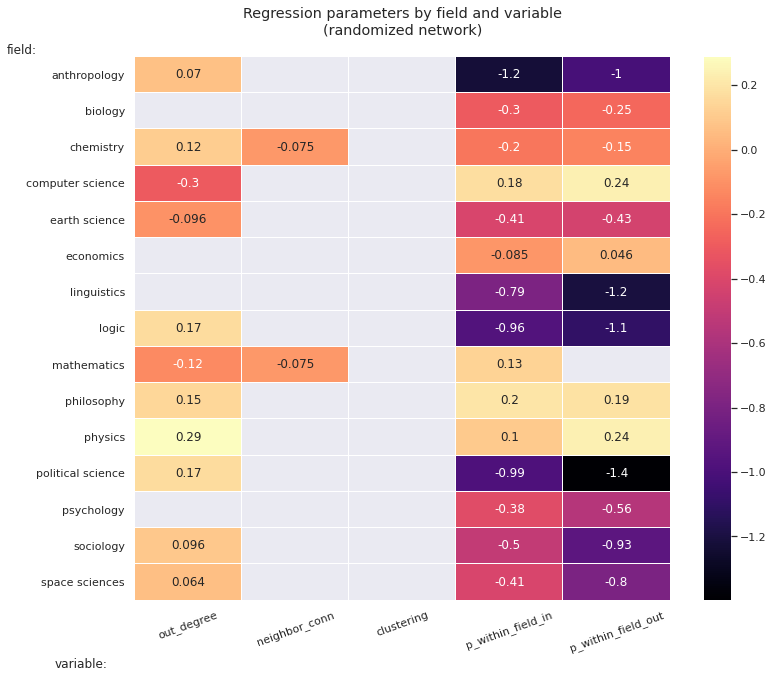

In [311]:
sns.heatmap(randomized_field_coeff_matrix, cmap="magma", annot=True, linewidth=0.01)
plt.xticks(rotation=20)
plt.ylabel("field:", rotation=0, position=(0, 1))
plt.xlabel("variable:", position=(-0.1, 0))
plt.title(
    "Regression parameters by field and variable\n(randomized network)\n",
    fontsize="large",
)

Text(0, 0.5, 'True positives')

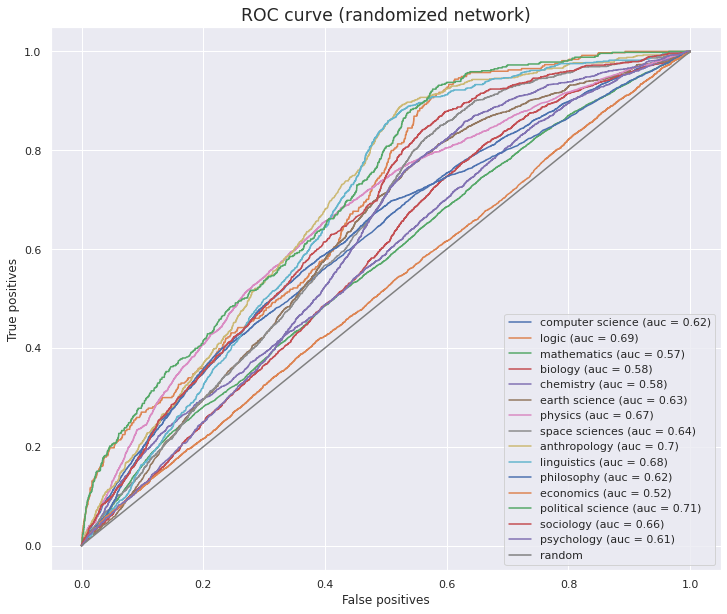

In [312]:
for f in reg_metrics.keys():

    plt.plot(
        reg_metrics[f]["false_pos"],
        reg_metrics[f]["true_pos"],
        label="{} (auc = {})".format(f, reg_metrics[f]["auc"].round(2)),
    )

plt.plot(np.linspace(0, 1), np.linspace(0, 1), c="grey", label="random")
plt.legend(loc=4)
plt.title("ROC curve (randomized network)", fontsize="x-large")
plt.xlabel("False positives")
plt.ylabel("True positives")

Text(0, 0.5, 'Recall')

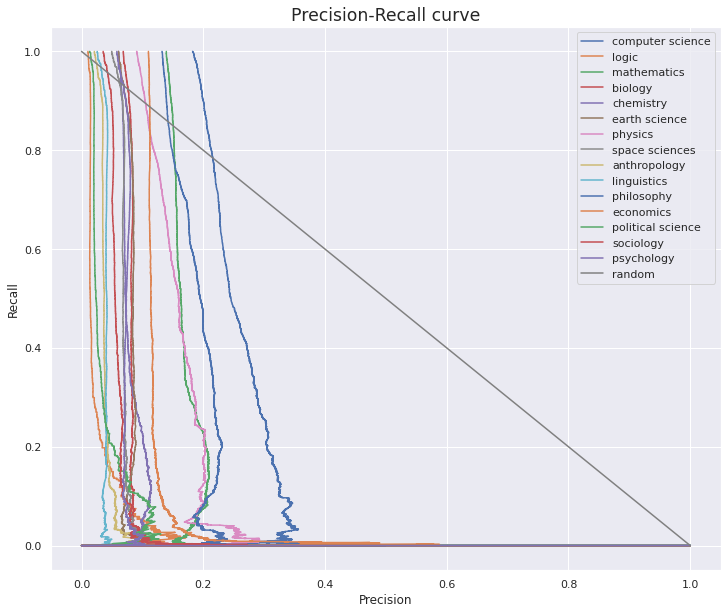

In [295]:
for f in reg_metrics.keys():

    plt.plot(
        reg_metrics[f]["prec"], reg_metrics[f]["rec"], label=f,
    )

plt.plot(np.linspace(0, 1), 1 - np.linspace(0, 1), c="grey", label="random")

plt.legend(loc=1)
plt.title("Precision-Recall curve", fontsize="x-large")
plt.xlabel("Precision")
plt.ylabel("Recall")